In [1]:
import os, sys
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="1" 
import numpy as np
import pandas as pd
import shutil
import pickle
import tqdm
from tqdm import tqdm
import xlsxwriter
import random
from random import shuffle
from math import log, floor
import re
import collections
from collections import Counter
import string
import unicodedata as udata
import pause, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

* 僅拿train的一對多來做統計
* 計算profile中api invocation call長度眾數
* 目前僅拿train of 一對多來生成文本給Sent2Vec

In [2]:
# corpus = []
# window_size = 6
# dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
# api_length = []
profile_length = []

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        for profile in hl_list:
            with open(profile,encoding='ISO 8859-1') as f:
                lines = f.read().splitlines()
            profile_length.append(len(lines))
            
#             for line in lines:
#                 temp = re.sub(dil," ",line)
#                 temp = temp.split(" ")
#                 temp = list(filter(None, temp))
#                 api_length.append(len(temp))
                
                
#                 temp = ' '.join(temp)
#                 corpus.append(temp)


    

100%|██████████| 175/175 [00:00<00:00, 341.45it/s]


In [3]:
def basic_statistics(all_length):
    '''
    input: length list of elements
    output1: mean、std、mode、min、q1、median(q2)、q3、max、iqr、outlier、far out
    output2: statistics graph、10%~90% form
    '''
    stat_dict = {}
    stat_dict['mean'] = np.mean(all_length)
    stat_dict['std'] = np.std(all_length)
    stat_dict['mode'] = np.argmax(np.bincount(all_length))
    stat_dict['min'] = np.min(all_length)
    stat_dict['q1'] = np.quantile(all_length,0.25)
    stat_dict['median'] = np.quantile(all_length,0.5)
    stat_dict['q3'] = np.quantile(all_length,0.75)
    stat_dict['max'] = np.max(all_length)
    stat_dict['iqr'] = stat_dict['q3'] - stat_dict['q1']
    stat_dict['outlier'] = stat_dict['q3'] + 1.5*stat_dict['iqr']
    stat_dict['far_out'] = stat_dict['q3'] + 3*stat_dict['iqr']
    for i in [10,20,30,40,50,60,70,80,90,100]:
        stat_dict[str(i)+'%'] = np.percentile(all_length,i)
    return pd.DataFrame.from_dict(stat_dict,orient='index',columns=['length'])

In [4]:
profile_stat_df = basic_statistics(profile_length)
print(np.percentile(profile_length,83.365)) # outlier長度=212 涵蓋83.365 data
profile_stat_df

212.0


,length
mean,141.490641
std,180.786531
mode,104.000000
min,11.000000
q1,37.000000
median,87.000000
q3,109.000000
max,1307.000000
iqr,72.000000
outlier,217.000000


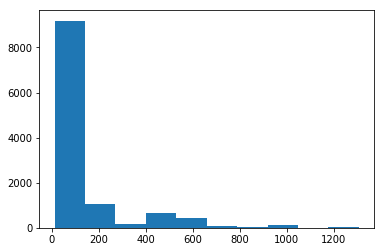

In [37]:
plt.hist(profile_length) #,bins=[10,20,30,40,50,60,70,80,90,100,110]
plt.show()
pro_df = pd.DataFrame(data={'profile':sorted(profile_length)})
pro_df.to_excel('data/tree-rep-profiles-partial/profile_dist.xlsx',index=False)

* remove too long profiles (processes)

In [5]:
outlier_len_profile = profile_stat_df.loc['outlier'].values[0]

In [6]:
# corpus = []
# window_size = 6
# dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
mv_dir = './data/tree-rep-profiles-partial/5.long/'
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
remove_pids = 0
nobyteseq = 0

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        for profile in hl_list:
            with open(profile,encoding='ISO 8859-1') as f:
                lines = f.read().splitlines()
            if len(lines)> outlier_len_profile:
                dest_path = mv_dir + fam + '/' + tree + '/'
                if not os.path.exists(dest_path):
                    os.makedirs(dest_path,exist_ok=True)
                shutil.move(profile,dest_path+profile.split('/')[-1])
                byteseq = profile.split('.profile')[0] + '_byterep.pickle'
                try:
                    shutil.move(byteseq,dest_path+byteseq.split('/')[-1])
                except FileNotFoundError:
                    print(fam,tree)
                    nobyteseq +=1
                remove_pids +=1
print('remove processes:',remove_pids,'No byteseq:',nobyteseq)
            

  6%|▌         | 10/175 [00:00<00:01, 99.59it/s]

5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1456
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1439
5.symmi_0.8 G1444
5.symmi_0.8 G1305
5.symmi_0.

 22%|██▏       | 38/175 [00:00<00:01, 123.03it/s]

39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
39.elkern_0.8 G259
127.gepys_0.8 G55
127.gepys_0.8 G55
127.gepys_0.8 G55
45.firseria_0.8 G246
45.firseria_0.8 G246
45.firseria_0.8 G246
45.firseria_0.8 G246
45.firseria_0.8 G246
45.firseria_0.8 G246
45.firseria_0.8 G246
45.firseria_0.8 G246
45.firseria_0.8 G249
45.firseria_0.8 G249
45.firseria_0.8 G249
45.firseria_0.8 G249
45.firseria_0.8 G247
45.firseria_0.8 G247
45.firseria_0.8 G247
45.firseria_0.8 G247
45.firseria_0.8 G247
45.firseria_0.8 G247
82.mydoom_0.8 G122
82.mydoom_0.8 G122
82.mydoom_0.8 G12

 33%|███▎      | 57/175 [00:00<00:01, 115.93it/s]

12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
12.loadmoney_0.8 G828
15.barys_0.8 G511
15.barys_0.8 G511
15.barys_0.8 G511
15.barys_0.8 G511
15.barys_0.8 G511
15.barys_0.8 G511


 43%|████▎     | 76/175 [00:00<00:00, 126.76it/s]

133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
133.ipamor_0.8 G101
154.hllp_0.8 G46
154.hllp_0.8 G46
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1267
11.virtob_0.8 G1205
11.virtob_0.8 G1205
11.virtob_0.8 G1200
11.virtob_0.8 G1186
11.virtob_0.8 G1183
11.virtob_0.8 G1261
11.virtob_0.8 G1261
11.virtob_0.8 G1261
11.virtob_0.8 G1261
11.virtob_0.8 G1255
11.virtob_0.8 G1255
11.virtob_0.8 G1255
11.virtob_0.8 G1242
11.virtob_0.8 G1242
11.virtob_0.8 G1242
11.virtob_0.8 G1242
11.virtob_0.8 G1209
125.rbot_0.8 G53
125.rbot_0.8 G53
125.rbot_0.8 G53
125.rbot_0.8 G5

 56%|█████▌    | 98/175 [00:00<00:00, 144.65it/s]

65.shipup_0.8 G138
65.shipup_0.8 G138
65.shipup_0.8 G138


 65%|██████▍   | 113/175 [00:00<00:00, 118.83it/s]

23.sality_0.8 G383
23.sality_0.8 G383
23.sality_0.8 G383
23.sality_0.8 G383
23.sality_0.8 G383
23.sality_0.8 G383
23.sality_0.8 G383
23.sality_0.8 G383
23.sality_0.8 G383
23.sality_0.8 G383
59.megasearch_0.8 G171
59.megasearch_0.8 G171
59.megasearch_0.8 G171
59.megasearch_0.8 G171
59.megasearch_0.8 G171
59.megasearch_0.8 G171
59.megasearch_0.8 G171
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G176
59.megasearch_0.8 G174
59.megasearch_0.8 G174
59.megasearch_0.8 G174
59.megasearch_0.8 G174
59.megasearch_0.8 G174
59.megasearch_0.8 G174
59.megasearch_0.8 G174
2.fakealert_0.8 G2037
2.fakealert_0.8 G2037
2.fakealert_0.8 G2108
2.fakealert_0.8 G2108
2.fakealert_0.8 G2108
2.fakealer

 72%|███████▏  | 126/175 [00:00<00:00, 118.82it/s]

20.hotbar_0.8 G413
20.hotbar_0.8 G413
20.hotbar_0.8 G413
20.hotbar_0.8 G413
20.hotbar_0.8 G413
20.hotbar_0.8 G413
20.hotbar_0.8 G413
20.hotbar_0.8 G413
20.hotbar_0.8 G413
20.hotbar_0.8 G399
20.hotbar_0.8 G409
20.hotbar_0.8 G409
20.hotbar_0.8 G409
20.hotbar_0.8 G409
20.hotbar_0.8 G409
20.hotbar_0.8 G409
20.hotbar_0.8 G392
20.hotbar_0.8 G410
20.hotbar_0.8 G410
20.hotbar_0.8 G410
20.hotbar_0.8 G410
20.hotbar_0.8 G410
20.hotbar_0.8 G410
20.hotbar_0.8 G410
20.hotbar_0.8 G410
96.mabezat_0.8 G76
96.mabezat_0.8 G76
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
18.sytro_0.8 G667
1

 83%|████████▎ | 146/175 [00:01<00:00, 134.21it/s]

17.expiro_0.8 G650
70.hoax_0.8 G86
70.hoax_0.8 G86
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376


 92%|█████████▏| 161/175 [00:01<00:00, 128.05it/s]

75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
75.fesber_0.8 G376
61.ircbot_0.8 G139
61.ircbot_0.8 G140
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
61.ircbot_0.8 G142
169.patched_0.8 G28
169.patched_0.8 G28
169.patched_0.8 G28
169.patch

100%|██████████| 175/175 [00:01<00:00, 118.49it/s]

9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G823
9.solimba_0.8 G820
9.solimba_0.8 G820
9.solimba_0.8 G820
9.solimba_0.8 G820
9.solimba_0.8 G820
9.solimba_0.8 G820
9.solimba_0.8 G827
9.solimba_0.8 G827
9.solimba_0.8 G827
9.solimba_0.8 G827
9.solimba_0.8 G827
9.solimba_0.8 G827
9.solimba_0.8 G790
32.browsefox_0.8 G345
32.browsefox_0.8 G345
32.browsefox_0.8 G345
32.browsefox_0.8 G345
32.browsefox_0.8 G345
32.browsefox_0.8 G345
remove processes: 1954 No byteseq: 1438


In [7]:
# dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
all_pids = []

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        hash_list = [f.split('/')[-1].split('_')[0] for f in hl_list]
        all_pids.extend(hash_list)
all_hash = set(all_pids)
len(all_hash) , len(all_pids) #濾掉過長的profile以後剩下的(samples, processes)

100%|██████████| 175/175 [00:00<00:00, 2664.20it/s]


(5997, 9800)

* family smaller than 15
* dict: key(fam): value(samples)

In [8]:
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
fam_pids_count = {}

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    tree_pids_count = []
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        tree_pids_count.append(len(hl_list))
    fam_pids_count[fam] = sum(tree_pids_count)

100%|██████████| 175/175 [00:00<00:00, 2916.74it/s]


In [9]:
fam_pids_count_df = pd.DataFrame.from_dict(fam_pids_count,orient='index',columns=['pids'])
fam_pids_count_df = fam_pids_count_df.sort_values(by=['pids'],ascending=False)
fam_pids_count_df

,pids
2.fakealert_0.8,1126
6.allaple_0.8,1000
4.zbot_0.8,633
5.symmi_0.8,429
8.ursu_0.8,426
11.virtob_0.8,329
9.solimba_0.8,318
48.rahack_0.8,292
10.zusy_0.8,247
14.vobfus_0.8,206


In [10]:
fam_pids_upper = fam_pids_count_df[fam_pids_count_df.pids > 15]
print('final processes#:',fam_pids_upper.pids.sum())
fam_pids_upper

final processes#: 9137


,pids
2.fakealert_0.8,1126
6.allaple_0.8,1000
4.zbot_0.8,633
5.symmi_0.8,429
8.ursu_0.8,426
11.virtob_0.8,329
9.solimba_0.8,318
48.rahack_0.8,292
10.zusy_0.8,247
14.vobfus_0.8,206


* move small families to 'smallFam' dir

In [11]:
fam_small_df = fam_pids_count_df[fam_pids_count_df.pids <= 15]
small_families = fam_small_df.index.tolist()
small_families

['107.zegost_0.8',
 '160.hllw_0.8',
 '151.downloadadmin_0.8',
 '178.installmonetizer_0.8',
 '52.startpage_0.8',
 '99.scar_0.8',
 '56.shiz_0.8',
 '39.elkern_0.8',
 '62.renos_0.8',
 '165.qukart_0.8',
 '85.aira_0.8',
 '163.bjlog_0.8',
 '95.bifrose_0.8',
 '110.fareit_0.8',
 '176.cryptolocker_0.8',
 '118.lydra_0.8',
 '113.chinky_0.8',
 '184.berbew_0.8',
 '79.medfos_0.8',
 '147.lethic_0.8',
 '86.gamevance_0.8',
 '155.vkopampi_0.8',
 '89.mywebsearch_0.8',
 '146.fynloski_0.8',
 '150.minggy_0.8',
 '106.nabucur_0.8',
 '112.almanahe_0.8',
 '117.koutodoor_0.8',
 '94.ndow_0.8',
 '105.crytex_0.8',
 '127.gepys_0.8',
 '69.onlinegames_0.8',
 '164.conduit_0.8',
 '90.chir_0.8',
 '177.imali_0.8',
 '192.dealply_0.8',
 '138.codecpack_0.8',
 '98.runouce_0.8',
 '123.archsms_0.8',
 '162.dialer_0.8',
 '159.otwycal_0.8',
 '189.veec_0.8',
 '187.asoecem_0.8',
 '61.ircbot_0.8',
 '108.wapomi_0.8',
 '168.amonetize_0.8',
 '82.mydoom_0.8',
 '120.jadtre_0.8',
 '126.banker_0.8',
 '122.adload_0.8',
 '170.alman_0.8',
 '73.

In [12]:
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
mv_dir = './data/tree-rep-profiles-partial/6.smallFam/'
if not os.path.exists(mv_dir):
    os.makedirs(mv_dir,exist_ok=True)

for fam in tqdm(fam_dir):
    if fam in small_families:
        src = os.path.join(root_dir,fam)
        dest = os.path.join(mv_dir,fam)
        shutil.move(src,dest)

mv_dir = './data/tree-rep-profiles-partial/7.emptyTree_of5.Long/'
if not os.path.exists(mv_dir):
    os.makedirs(mv_dir,exist_ok=True)

fam_dir = next(os.walk(root_dir))[1]
empty_tree = 0
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    fam_tree = {}
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        if len(hl_list) == 0: #移除tree底下的member僅有0個者
            shutil.move(root_dir + fam +  '/' + tree ,mv_dir+fam+'/'+tree)
            empty_tree +=1
print('Empty Tree#:',empty_tree)
        
fam_dir = next(os.walk(root_dir))[1]
tree_count = 0
all_pids= []
for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    tree_count += len(tree_dir)
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        hash_list = [f.split('/')[-1].split('_')[0] for f in hl_list]
        all_pids.extend(hash_list)
all_hash = set(all_pids)
len(all_hash) , len(all_pids),tree_count,len(fam_dir) #final dataset的(samples, processes,trees#,fam#)

100%|██████████| 80/80 [00:00<00:00, 1434.45it/s]

Empty Tree#: 168


(5668, 9137, 797, 80)

## Train, Dev , Test Set

In [13]:
root_dir = './data/tree-rep-profiles-partial/normal/'
unk_fam = './data/tree-rep-profiles-partial/6.smallFam/'
all_df = pd.read_csv('./data/tree-rep-profiles-partial/profile2family_df.csv')
fam_dir = next(os.walk(root_dir))[1]
fam_unk = next(os.walk(unk_fam))[1]
normal_fam = [x.split('_')[0] for x in fam_dir]
sorted(fam_dir)#正常最後要拿下去train的family

['10.zusy_0.8',
 '103.yantai_0.8',
 '104.mresmon_0.8',
 '11.virtob_0.8',
 '111.vbran_0.8',
 '12.loadmoney_0.8',
 '121.fiseria_0.8',
 '124.avmh_0.8',
 '13.graftor_0.8',
 '133.ipamor_0.8',
 '135.pcclient_0.8',
 '14.vobfus_0.8',
 '149.hidp_0.8',
 '15.barys_0.8',
 '156.vtflooder_0.8',
 '16.soft_0.8',
 '17.expiro_0.8',
 '18.sytro_0.8',
 '19.razy_0.8',
 '2.fakealert_0.8',
 '20.hotbar_0.8',
 '21.ramnit_0.8',
 '22.domaiq_0.8',
 '23.sality_0.8',
 '24.kryptik_0.8',
 '25.installcore_0.8',
 '26.lmn_0.8',
 '27.softpulse_0.8',
 '28.strictor_0.8',
 '29.delf_0.8',
 '30.mplug_0.8',
 '31.kdz_0.8',
 '32.browsefox_0.8',
 '33.autoit_0.8',
 '34.downloa_0.8',
 '35.nimnul_0.8',
 '36.morstar_0.8',
 '37.parite_0.8',
 '38.msil_0.8',
 '4.zbot_0.8',
 '40.tepfer_0.8',
 '41.outbrowse_0.8',
 '42.sirefef_0.8',
 '43.mira_0.8',
 '44.screensaver_0.8',
 '45.firseria_0.8',
 '46.killav_0.8',
 '47.somoto_0.8',
 '48.rahack_0.8',
 '49.upatre_0.8',
 '5.symmi_0.8',
 '50.brresmon_0.8',
 '51.shodi_0.8',
 '54.soltern_0.8',
 '55.zyg

* remove empty tree

In [14]:
# mv_dir = './data/tree-rep-profiles-partial/7.emptyTree_of5.Long/'
# if not os.path.exists(mv_dir):
#     os.makedirs(mv_dir,exist_ok=True)

# empty_tree = 0
# for fam in tqdm(fam_dir):
#     tree_dir = next(os.walk(root_dir + fam))[1]
#     fam_tree = {}
#     for tree in tree_dir:
#         in_directory = root_dir + fam +  '/' + tree + '/'
#         hl_list = next(os.walk(in_directory))[2]
#         hl_list = [os.path.join(in_directory, f) for f in hl_list]
#         hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
#         if len(hl_list) == 0:
#             shutil.move(root_dir + fam +  '/' + tree ,mv_dir+fam+'/'+tree)
#             empty_tree +=1
# print('Empty Tree#:',empty_tree)

move file to valid & test

In [15]:
valid_dir = './data/tree-rep-profiles-partial/DEV/'
test_dir = './data/tree-rep-profiles-partial/TEST/'

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    fam_tree = {}
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        fam_tree[tree]=len(hl_list)
        temp = pd.DataFrame.from_dict(fam_tree,orient='index',columns=['pids'])
        temp = temp.sort_values(by=['pids'])
    if len(fam_tree)>2: #拿一棵樹給dev一顆給train
        test_tree_name = temp.iloc[0].name
        valid_tree_name = temp.iloc[1].name
        dest_path = valid_dir + fam + '/' 
        ori_path = root_dir + fam +  '/' + valid_tree_name + '/'
        if not os.path.exists(dest_path):
            os.makedirs(dest_path,exist_ok=True)
        shutil.move(ori_path,dest_path)
        ori_path = root_dir + fam +  '/' + test_tree_name + '/'
        dest_path = test_dir + fam + '/' 
        if not os.path.exists(dest_path):
            os.makedirs(dest_path,exist_ok=True)
        shutil.move(ori_path,dest_path)
    else: #最大tree挑選兩個sample
        VTtree = temp.iloc[-1].name 
        in_directory = root_dir + fam +  '/' + VTtree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith((".profile")), hl_list))
        hl_list = sorted(hl_list)
        dest_path = valid_dir + fam + '/' + VTtree + '/'
        if not os.path.exists(dest_path):
            os.makedirs(dest_path,exist_ok=True)
        ran = random.randint(0,len(hl_list)-1)
        shutil.move(hl_list[ran],dest_path + hl_list[ran].split('/')[-1])
        byteseq = hl_list[ran].split('.profile')[0] + '_byterep.pickle'
        try:
            shutil.move(byteseq,dest_path + byteseq.split('/')[-1])
        except FileNotFoundError:
            print('No Byte String:',fam,tree)
        dest_path = test_dir + fam + '/' + VTtree + '/'
        if not os.path.exists(dest_path):
            os.makedirs(dest_path,exist_ok=True)
        try:
            shutil.move(hl_list[ran+1],dest_path + hl_list[ran+1].split('/')[-1]) #所有同樣名稱的都要拿? 可能會產生空樹
            byteseq = hl_list[ran].split('.profile')[0] + '_byterep.pickle'
            try:
                shutil.move(byteseq,dest_path + byteseq.split('/')[-1])
            except FileNotFoundError:
                print('No Byte String:',fam,tree)
        except IndexError:
            shutil.move(hl_list[ran-1],dest_path + hl_list[ran-1].split('/')[-1])
            byteseq = hl_list[ran].split('.profile')[0] + '_byterep.pickle'
            try:
                shutil.move(byteseq,dest_path + byteseq.split('/')[-1])
            except FileNotFoundError:
                print('No Byte String:',fam,tree)
#         for valid in hl_list:
#             shutil.move(valid,dest_path+valid.split('/[-1]'))
#         shutil.copy2()


 35%|███▌      | 28/80 [00:00<00:00, 121.24it/s]

No Byte String: 103.yantai_0.8 G48
No Byte String: 88.clickdownload_0.8 G69
No Byte String: 54.soltern_0.8 G175
No Byte String: 54.soltern_0.8 G175
No Byte String: 66.bdmj_0.8 G119
No Byte String: 133.ipamor_0.8 G102
No Byte String: 104.mresmon_0.8 G48


 65%|██████▌   | 52/80 [00:00<00:00, 114.93it/s]

No Byte String: 124.avmh_0.8 G32
No Byte String: 111.vbran_0.8 G52
No Byte String: 65.shipup_0.8 G130
No Byte String: 149.hidp_0.8 G51
No Byte String: 71.eggnog_0.8 G116
No Byte String: 71.eggnog_0.8 G116


100%|██████████| 80/80 [00:00<00:00, 125.15it/s]

No Byte String: 156.vtflooder_0.8 G29
No Byte String: 81.picsys_0.8 G115
No Byte String: 48.rahack_0.8 G515
No Byte String: 48.rahack_0.8 G515


* 計算train : valid : test比例
* 依照比例分配unk_pid數目

In [26]:
def statistic_hash_pids(root_dir):
    fam_dir = next(os.walk(root_dir))[1]
    all_pids= []
    all_pid_list = []
    tree_count = 0
    for fam in tqdm(fam_dir):
        tree_dir = next(os.walk(root_dir + fam))[1]
        tree_count += len(tree_dir)
        for tree in tree_dir:
            in_directory = root_dir + fam +  '/' + tree + '/'
            hl_list = next(os.walk(in_directory))[2]
            hl_list = [os.path.join(in_directory, f) for f in hl_list]
            hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
            hash_list = [f.split('/')[-1].split('_')[0] for f in hl_list]
            pid_list = [f.split('/')[-1] for f in hl_list]
            all_pids.extend(hash_list)
            all_pid_list.extend(pid_list)
#             print(fam,len(hash_list)) #DEBUG
    all_hash = set(all_pids)
    print('Samples#:',len(all_hash),',Processes#:',len(all_pids),',Trees#:',tree_count)
    return all_hash, list(set(all_pid_list))

In [17]:
root_dir = './data/tree-rep-profiles-partial/DEV/'
samples_hash_valid = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/TEST/'
samples_hash_test = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/normal/'
samples_hash_train = statistic_hash_pids(root_dir) 

  0%|          | 0/80 [00:00<?, ?it/s]

Samples#: 240 Processes#: 267 Trees#: 80
Samples#: 181 Processes#: 216 Trees#: 80


100%|██████████| 80/80 [00:00<00:00, 1410.10it/s]

Samples#: 5436 Processes#: 8654 Trees#: 665


In [18]:
# 純統計
unk_pid = []
for fam in tqdm(fam_unk):
    tree_dir = next(os.walk(unk_fam + fam))[1]
    tree_count += len(tree_dir)
    for tree in tree_dir:
        in_directory = unk_fam + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        hash_list = [f.split('/')[-1].split('.')[0] for f in hl_list]
        for pid in hash_list:
            profile_df = all_df[all_df.profile == pid]
            if profile_df[normal_fam].sum().sum() == 0:
                unk_pid.append(profile_df.profile.values[0])
unk_hash = [x.split('_')[0] for x in unk_pid]
unk_hash = list(set(unk_hash))
print('UNK_Samples#:',len(unk_hash),'UNK_Processes#:',len(unk_pid))

100%|██████████| 95/95 [00:01<00:00, 55.83it/s]

UNK_Samples#: 218 UNK_Processes#: 274


* 依照hash來分valid,test,train set
* 利用random比例來丟同樣samples到同一個set當中

In [19]:
train_unk_path = './data/tree-rep-profiles-partial/normal/0.unknown/G0/'
valid_unk_path = './data/tree-rep-profiles-partial/DEV/0.unknown/G0/'
test_unk_path = './data/tree-rep-profiles-partial/TEST/0.unkwown/G0/'
if not os.path.exists(train_unk_path):
    os.makedirs(train_unk_path,exist_ok=True)
if not os.path.exists(valid_unk_path):
    os.makedirs(valid_unk_path,exist_ok=True)
if not os.path.exists(test_unk_path):
    os.makedirs(test_unk_path,exist_ok=True)

used_hashes = []
for fam in tqdm(fam_unk):
    tree_dir = next(os.walk(unk_fam + fam))[1]
    tree_count += len(tree_dir)
    for tree in tree_dir:
        in_directory = unk_fam + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        hash_list = [f.split('/')[-1].split('.')[0] for f in hl_list]
        for pid in hash_list:
            profile_df = all_df[all_df.profile == pid]
            if profile_df[normal_fam].sum().sum() == 0:
                unk_hash = profile_df.profile.values[0].split('_')[0]
                if unk_hash in set(used_hashes):
                    break
                used_hashes.append(unk_hash)
                ran = random.randint(1,len(samples_hash_train)+len(samples_hash_valid)+len(samples_hash_test))
                unk_files = []
                duplicate_pid = []
                for filepath in Path(unk_fam).glob('**/'+unk_hash+'*'):
                    pid = str(filepath).split('/')[-1]
                    if pid in set(duplicate_pid):
                        break
                    duplicate_pid.append(pid)
                    unk_files.append(filepath)
                unk_files = list(set(unk_files))
                if ran <= len(samples_hash_valid): #valid
                    for file in unk_files:
                        shutil.move(str(file),valid_unk_path)
                elif ran < len(samples_hash_valid)+ len(samples_hash_test): #test
                    for file in unk_files:
                        shutil.move(str(file),test_unk_path)
                else: #train
                    for file in unk_files:
                        shutil.move(str(file),train_unk_path)
                    

100%|██████████| 95/95 [00:03<00:00, 30.74it/s]


In [27]:
# trees# 要減1
root_dir = './data/tree-rep-profiles-partial/DEV/'
samples_hash_valid, samples_pid_valid = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/TEST/'
samples_hash_test, samples_pid_test = statistic_hash_pids(root_dir) 
root_dir = './data/tree-rep-profiles-partial/normal/'
samples_hash_train, samples_pid_train = statistic_hash_pids(root_dir) 

100%|██████████| 81/81 [00:00<00:00, 1324.54it/s]

Samples#: 246 Processes#: 274 Trees#: 81
Samples#: 193 Processes#: 228 Trees#: 81
Samples#: 5596 Processes#: 8883 Trees#: 666


* prepare Sent2Vec training data
* save profile file name of [train, dev, test] to pickle

In [41]:
pickle.dump(file=open('./data/tree-rep-profiles-partial/TRAIN_pidNames.pkl','wb'),obj=samples_pid_train)
pickle.dump(file=open('./data/tree-rep-profiles-partial/DEV_pidNames.pkl','wb'),obj=samples_pid_valid)
pickle.dump(file=open('./data/tree-rep-profiles-partial/TEST_pidNames.pkl','wb'),obj=samples_pid_test)

In [38]:
dil= r"[,.;\-+^()/@#?!&$:{}\\*%~\'\"]+\ *" #等號、底線被保留
root_dir = './data/tree-rep-profiles-partial/normal/'
fam_dir = next(os.walk(root_dir))[1]
api_length = []
profile_length = []

for fam in tqdm(fam_dir):
    tree_dir = next(os.walk(root_dir + fam))[1]
    for tree in tree_dir:
        in_directory = root_dir + fam +  '/' + tree + '/'
        hl_list = next(os.walk(in_directory))[2]
        hl_list = [os.path.join(in_directory, f) for f in hl_list]
        hl_list = list(filter(lambda f: f.endswith(".profile"), hl_list))
        for profile in hl_list:
            with open(profile,encoding='ISO 8859-1') as f:
                lines = f.read().splitlines()
            for line in lines:
                temp = re.sub(dil," ",line)
                temp = temp.split(" ")
                temp = list(filter(None, temp))
                api_length.append(len(temp))

100%|██████████| 81/81 [00:05<00:00,  9.21it/s]


In [39]:
basic_statistics(api_length)

,length
mean,12.301909
std,2.930202
mode,13.000000
min,3.000000
q1,12.000000
median,13.000000
q3,13.000000
max,33.000000
iqr,1.000000
outlier,14.500000
